In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 09:12:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read in dataset
data = spark.read.csv('Dataset/heart_attack_dataset.csv', header=True, inferSchema=True)

## Data Selection

In [3]:
# Drop a column
column_to_drop = "Patient ID"
data = data.drop(column_to_drop)

# Show the resulting DataFrame
data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Systolic: integer (nullable = true)
 |-- Diastolic : integer (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History (1: Yes): integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems (1 : Yes): integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: integer (n

In [4]:
# Count the number of columns
num_columns = len(data.columns)

# Print the results
print(f"Number of columns: {num_columns}")

Number of columns: 26


In [5]:
# Perform value counts for the variable "Heart Attack Risk (1: Yes)"
value_counts = data.groupBy("Heart Attack Risk (1: Yes)").count()

# Show the value counts
value_counts.show()

+--------------------------+-----+
|Heart Attack Risk (1: Yes)|count|
+--------------------------+-----+
|                         1|  925|
|                         0| 1574|
+--------------------------+-----+



## Data Cleaning

In [6]:
from pyspark.sql.functions import when

# Calculate mode of the "Stress Level" column
mode_value = data.groupBy("Stress Level").count().orderBy("count", ascending=False).first()[0]

# Impute missing values with the mode
data = data.withColumn("Stress Level", when(data["Stress Level"].isNull(), mode_value).otherwise(data["Stress Level"]))

In [8]:
from pyspark.sql.functions import mean

exercise_mean = data.select(mean("Exercise Hours Per Week")).collect()[0][0]
sedentary_mean = data.select(mean("Sedentary Hours Per Day")).collect()[0][0]
bmi_mean = data.select(mean("BMI")).collect()[0][0]
sleep_mean = data.select(mean("Sleep Hours Per Day")).collect()[0][0]

# Impute missing values with the mean for the "age" column
data = data.withColumn("Exercise Hours Per Week", when(data["Exercise Hours Per Week"].isNull(), exercise_mean).otherwise(data["Exercise Hours Per Week"]))
data = data.withColumn("Sedentary Hours Per Day", when(data["Sedentary Hours Per Day"].isNull(), sedentary_mean).otherwise(data["Sedentary Hours Per Day"]))
data = data.withColumn("BMI", when(data["BMI"].isNull(), bmi_mean).otherwise(data["BMI"]))
data = data.withColumn("Sleep Hours Per Day", when(data["Sleep Hours Per Day"].isNull(), sleep_mean).otherwise(data["Sleep Hours Per Day"]))

In [9]:
from pyspark.sql.functions import col, sum as spark_sum

# List of columns to check for missing values
columns = data.columns

# Create a DataFrame to store the count of missing values for each column
missing_values = data.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns])

# Filter columns with missing values
missing_columns = missing_values.columns
missing_columns_with_values = [col_name for col_name in missing_columns if missing_values.select(col_name).head()[col_name] > 0]

# Create a new DataFrame with columns that have missing values
missing_values_filtered = missing_values.select(*missing_columns_with_values)

# Show the count of missing values for columns with missing values
missing_values_filtered.show()

++
||
++
||
++



In [10]:
# Count the number of rows
num_rows1 = data.count()

# Count the number of columns
num_columns1 = len(data.columns)

# Print the results
print(f"Number of rows: {num_rows1}")
print(f"Number of columns: {num_columns1}")

Number of rows: 2499
Number of columns: 26


In [11]:
data = data.filter(data["Heart Rate"] != 200)
data = data.filter(data["Exercise Hours Per Week"] != 40.546388)
data = data.filter(data["Stress Level"] != 20)
data = data.filter(data["Sleep Hours Per Day"] != 20)

In [13]:
# Print the results
print(f"Number of rows: {data.count()}")
print(f"Number of columns: {len(data.columns)}")

Number of rows: 2495
Number of columns: 26


In [16]:
from pyspark.sql.types import IntegerType, DoubleType, StructType, StructField, StringType

# Function to find extreme values for a column

def find_extreme_values(data, column):
    # Calculate Q1 and Q3
    quantiles = data.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter extreme values
    extreme_values_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return extreme_values_df

exclude_columns = ["Smoking"]

# Iterate through each column and find extreme values if the column is numeric
for column in data.columns:
    if column not in exclude_columns and isinstance(data.schema[column].dataType, (IntegerType, DoubleType)):
        extreme_values_df = find_extreme_values(data, column)
        if extreme_values_df.count() > 0:
            extreme_values = [row[column] for row in extreme_values_df.collect()]
            for value in extreme_values:
                print(f"{column} has an extreme value: {value}")
        else:
            print(f"No extreme values found for {column}")


No extreme values found for Age
No extreme values found for Cholesterol
No extreme values found for Systolic
No extreme values found for Diastolic 
No extreme values found for Heart Rate
No extreme values found for Diabetes
No extreme values found for Family History (1: Yes)
No extreme values found for Obesity
No extreme values found for Alcohol Consumption
No extreme values found for Exercise Hours Per Week
No extreme values found for Previous Heart Problems (1 : Yes)
No extreme values found for Medication Use
No extreme values found for Stress Level
No extreme values found for Sedentary Hours Per Day
No extreme values found for Income
No extreme values found for BMI
No extreme values found for Triglycerides
No extreme values found for Physical Activity Days Per Week
No extreme values found for Sleep Hours Per Day
No extreme values found for Heart Attack Risk (1: Yes)


## Construct of new variables / features

In [17]:
from pyspark.sql.functions import when

# Create Age Group column based on age bins
data = data.withColumn(
    "Age Group",
    when((col("Age") >= 18) & (col("Age") < 30), "young adults")
    .when((col("Age") >= 30) & (col("Age") < 60), "middle age")
    .when((col("Age") >= 60) & (col("Age") <= 103), "old")
)

In [18]:
print(f"Number of columns: {len(data.columns)}")

Number of columns: 27


In [19]:
data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Systolic: integer (nullable = true)
 |-- Diastolic : integer (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History (1: Yes): integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems (1 : Yes): integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: double (nu

In [20]:
# Perform value counts for the variable "Heart Attack Risk (1: Yes)"
value_counts = data.groupBy("Age Group").count()

# Show the value counts
value_counts.show()

+------------+-----+
|   Age Group|count|
+------------+-----+
|         old| 1045|
|  middle age| 1001|
|young adults|  449|
+------------+-----+



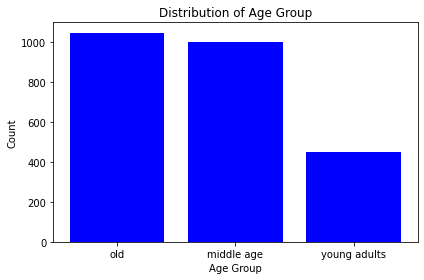

In [25]:
import matplotlib.pyplot as plt

# Compute the distribution of the "Country" variable
agegroup_distribution = data.groupBy("Age Group").count()

agegroup_distribution_local = agegroup_distribution.toLocalIterator()

# Prepare data for plotting
agegroup = []
counts = []
for row in agegroup_distribution_local:
    agegroup.append(row["Age Group"])
    counts.append(row["count"])

# Plot the bar graph
plt.bar(agegroup, counts, color='blue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Age Group')
plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

In [27]:
from pyspark.sql.functions import count, lit

# Perform value counts for the variable "Heart Attack Risk (1: Yes)"
total_count = data.count()

value_counts = data.groupBy("Heart Attack Risk (1: Yes)").count()
value_counts_percentage = value_counts.withColumn("percentage", (col("count") / total_count) * 100)

# Show the value counts
value_counts_percentage.show()

+--------------------------+-----+-----------------+
|Heart Attack Risk (1: Yes)|count|       percentage|
+--------------------------+-----+-----------------+
|                         1|  922|36.95390781563127|
|                         0| 1573|63.04609218436874|
+--------------------------+-----+-----------------+



In [36]:
import random


# Count the number of samples in each class
class_counts = data.groupBy("Heart Attack Risk (1: Yes)").count().collect()
count_0 = next(row['count'] for row in class_counts if row['Heart Attack Risk (1: Yes)'] == 0)
count_1 = next(row['count'] for row in class_counts if row['Heart Attack Risk (1: Yes)'] == 1)

# Determine the minority and majority classes
minority_class = 1 if count_1 < count_0 else 0
majority_class = 0 if minority_class == 1 else 1
minority_count = min(count_0, count_1)

# Sample from the majority class
majority_class_df = data.filter(col("Heart Attack Risk (1: Yes)") == majority_class)
sampled_majority_class_df = majority_class_df.sample(False, minority_count / count_0)

# Get all minority class samples
minority_class_df = data.filter(col("Heart Attack Risk (1: Yes)") == minority_class)

# Combine both classes to get a balanced DataFrame
balanced_data = sampled_majority_class_df.union(minority_class_df)

# Count the number of samples in each class in the balanced dataset
balanced_class_counts = balanced_data.groupBy("Heart Attack Risk (1: Yes)").count()
balanced_class_counts.show()


+--------------------------+-----+
|Heart Attack Risk (1: Yes)|count|
+--------------------------+-----+
|                         0|  936|
|                         1|  922|
+--------------------------+-----+



In [38]:
# Save the balanced DataFrame to CSV
#balanced_data.write.csv("balanced_heartdata.csv", header=True)

In [43]:
# Read in dataset
balanced_data = spark.read.csv('Dataset/balanced_heartdata.csv', header=True, inferSchema=True)

In [44]:
balanced_data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Systolic: integer (nullable = true)
 |-- Diastolic: integer (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History (1: Yes): integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems (1 : Yes): integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: double (nul

In [45]:
print(f"Number of rows: {balanced_data.count()}")
print(f"Number of columns: {len(balanced_data.columns)}")

Number of rows: 1858
Number of columns: 27


## Data Integration

In [46]:
# Read in dataset
file1 = spark.read.csv('Dataset/heart_data_10%(1).csv', header=True, inferSchema=True)
file2 = spark.read.csv('Dataset/heart_data_10%(2).csv', header=True, inferSchema=True)

In [47]:
print(f"Number of rows: {file1.count()}")
print(f"Number of columns: {len(file1.columns)}")

print(f"Number of rows: {file2.count()}")
print(f"Number of columns: {len(file2.columns)}")

Number of rows: 500
Number of columns: 27
Number of rows: 500
Number of columns: 27


In [48]:
# Merge vertically
merge_data = file1.union(file2)

In [51]:
print(f"Number of rows: {merge_data.count()}")
print(f"Number of columns: {len(merge_data.columns)}")

Number of rows: 1000
Number of columns: 27


In [50]:
# Save the balanced DataFrame to CSV
#merge_data.write.csv("merge_data.csv", header=True)

##  Reformatting data

In [52]:
merge_data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Systolic: integer (nullable = true)
 |-- Diastolic : integer (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History (1: Yes): integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems (1 : Yes): integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: integer (n

In [53]:
from pyspark.sql.functions import col, sum as spark_sum

# List of columns to check for missing values
columns = merge_data.columns

# Create a DataFrame to store the count of missing values for each column
missing_values = merge_data.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns])

# Filter columns with missing values
missing_columns = missing_values.columns
missing_columns_with_values = [col_name for col_name in missing_columns if missing_values.select(col_name).head()[col_name] > 0]

# Create a new DataFrame with columns that have missing values
missing_values_filtered = missing_values.select(*missing_columns_with_values)

# Show the count of missing values for columns with missing values
missing_values_filtered.show()

++
||
++
||
++

